# Install xgboost

In [48]:
!pip install xgboost


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import libraries

In [49]:
import sys                                                  # Read system parameters.
import numpy as np                                          # Work with multi-dimensional arrays.
import pandas as pd                                         # Manipulate and analyze data.
import matplotlib                                           # Create and format charts.
import matplotlib.pyplot as plt
import seaborn as sns                                       # Make charting easier.
import sklearn                                              # Train and evaluate machine learning models.
from sklearn.model_selection import train_test_split, \
                                    learning_curve, \
                                    GridSearchCV
from sklearn.linear_model import LinearRegression, \
                                 ElasticNet
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, \
                            mean_absolute_error, \
                            mean_squared_error
from sklearn.dummy import DummyRegressor
import xgboost                                              # Build gradient boosting models.
from xgboost import XGBRegressor
import pickle                                               # Save Python objects as binary files.
import warnings                                             # Suppress warnings.
warnings.filterwarnings('ignore')

# Ensure results are reproducible.
np.random.seed(1)

# Summarize software libraries used.
print('Libraries used in this project:')
print('- Python {}'.format(sys.version))
print('- NumPy {}'.format(np.__version__))
print('- pandas {}'.format(pd.__version__))
print('- Matplotlib {}'.format(matplotlib.__version__))
print('- Seaborn {}'.format(sns.__version__))
print('- scikit-learn {}'.format(sklearn.__version__))
print('- XGBoost {}'.format(xgboost.__version__))

Libraries used in this project:
- Python 3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]
- NumPy 2.1.1
- pandas 2.2.3
- Matplotlib 3.9.2
- Seaborn 0.13.2
- scikit-learn 1.6.1
- XGBoost 3.0.1


# Load and preview the data

In [50]:
users_data = pd.read_pickle('users_data_final.pickle')

users_data.head(n = 5)

,user_id,number_transactions,total_amount_usd,job_management,job_technician,job_entrepreneur,job_blue-collar,job_retired,job_admin.,job_services,...,duration,campaign,pdays,previous,term_deposit,device_desktop,device_tablet,single,age_group_encoded,month_joined
0,9231c446-cb16-4b2b-a7f7-ddfc8b25aaf6,3.0,2143.00,1,0,0,0,0,0,0,...,261,1,-1,0,False,0,0,0,4,8
1,bb92765a-08de-4963-b432-496524b39157,0.0,1369.42,0,1,0,0,0,0,0,...,151,1,-1,0,False,1,0,1,2,7
2,573de577-49ef-42b9-83da-d3cfb817b5c1,2.0,2.00,0,0,1,0,0,0,0,...,76,1,-1,0,False,0,0,0,1,6
3,d6b66b9d-7c8f-4257-a682-e136f640b7e3,0.0,1369.42,0,0,0,1,0,0,0,...,92,1,-1,0,False,0,1,0,3,6
4,fade0b20-7594-4d9a-84cd-c02f79b1b526,1.0,1.00,0,0,0,0,0,0,0,...,198,1,-1,0,False,0,0,1,1,8


In [51]:
#Check the shape of the data
users_data.shape

(45179, 33)

In [52]:
#Check the data types
users_data.dtypes

user_id                 object
number_transactions    float64
total_amount_usd       float64
job_management           int64
job_technician           int64
job_entrepreneur         int64
job_blue-collar          int64
job_retired              int64
job_admin.               int64
job_services             int64
job_self-employed        int64
job_unemployed           int64
job_housemaid            int64
job_student              int64
education_tertiary       int64
education_secondary      int64
education_Unknown        int64
education_primary        int64
default                   bool
housing                   bool
loan                      bool
contact_cellular         int64
contact_telephone        int64
duration                 int64
campaign                 int64
pdays                    int64
previous                 int64
term_deposit              bool
device_desktop           int64
device_tablet            int64
single                   uint8
age_group_encoded         int8
month_jo

In [53]:
#Explore the distribution of the target variable
users_data.total_amount_usd.describe()

count     45179.000000
mean       1369.751283
std        2704.291321
min       -8019.000000
25%         160.000000
50%         862.000000
75%        1369.420000
max      102127.000000
Name: total_amount_usd, dtype: float64

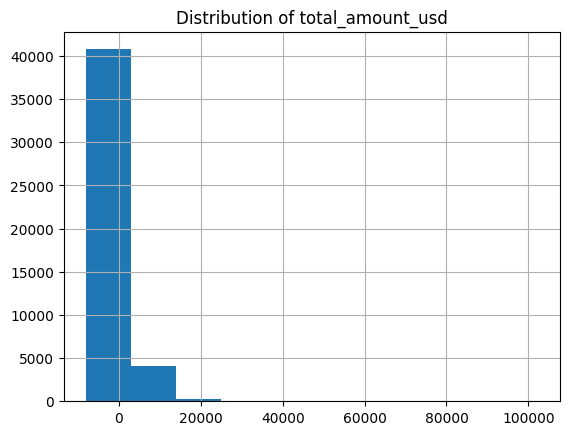

In [54]:
#Visualize the distribution of the target variable
users_data.total_amount_usd.hist()
plt.title('Distribution of total_amount_usd');


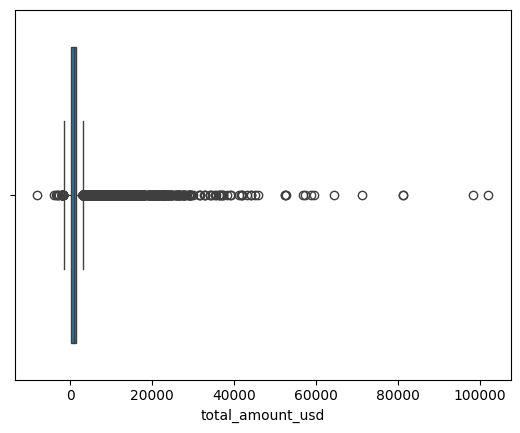

In [55]:

sns.boxplot(users_data.total_amount_usd, orient = 'h');

In [56]:
#Identify and remove the outliers
q1 = np.percentile(users_data.total_amount_usd, 25)
q3 = np.percentile(users_data.total_amount_usd, 75)
iqr = q3 - q1

lb = q1 - 1.5 * iqr
ub = q3 + 1.5 * iqr

print('Lower bound:', round(lb, 2))
print('Upper bound:', round(ub, 2))

Lower bound: -1654.13
Upper bound: 3183.55


In [57]:
print('Number of users with total_amount_usd greater than UB:',
      users_data[(users_data.total_amount_usd >= ub)].shape[0])
print('Number of users with total_amount_usd lower than LB:  ',
      users_data[(users_data.total_amount_usd <= lb)].shape[0])

Number of users with total_amount_usd greater than UB: 4110
Number of users with total_amount_usd lower than LB:   26


In [58]:
users_data_wout_outliers = \
users_data[(users_data.total_amount_usd < ub) \
           & (users_data.total_amount_usd > lb)]

users_data_wout_outliers.shape

(41043, 33)

In [59]:
#Explore the dataset with the outliers removed
users_data_wout_outliers.describe()

,number_transactions,total_amount_usd,job_management,job_technician,job_entrepreneur,job_blue-collar,job_retired,job_admin.,job_services,job_self-employed,...,contact_telephone,duration,campaign,pdays,previous,device_desktop,device_tablet,single,age_group_encoded,month_joined
count,41043.000000,41043.000000,41043.000000,41043.000000,41043.000000,41043.000000,41043.000000,41043.000000,41043.000000,41043.000000,...,41043.000000,41043.000000,41043.000000,41043.000000,41043.000000,41043.000000,41043.000000,41043.000000,41043.000000,41043.000000
mean,3.131179,793.578253,0.202032,0.169237,0.033087,0.220257,0.047657,0.116488,0.094316,0.034427,...,0.062203,256.095363,2.776527,40.205273,0.568111,0.267110,0.122018,0.284775,2.122067,6.499744
std,3.916997,761.407759,0.401521,0.374966,0.178867,0.414425,0.213043,0.320813,0.292271,0.182326,...,0.241527,254.777008,3.120160,100.917760,2.318308,0.442456,0.327311,0.451312,1.094556,3.425208
min,0.000000,-1636.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,123.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,103.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
50%,2.000000,659.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,179.000000,2.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,7.000000
75%,3.000000,1369.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,317.000000,3.000000,-1.000000,0.000000,1.000000,0.000000,1.000000,3.000000,9.000000
max,20.000000,3181.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,3881.000000,58.000000,871.000000,275.000000,1.000000,1.000000,1.000000,6.000000,12.000000


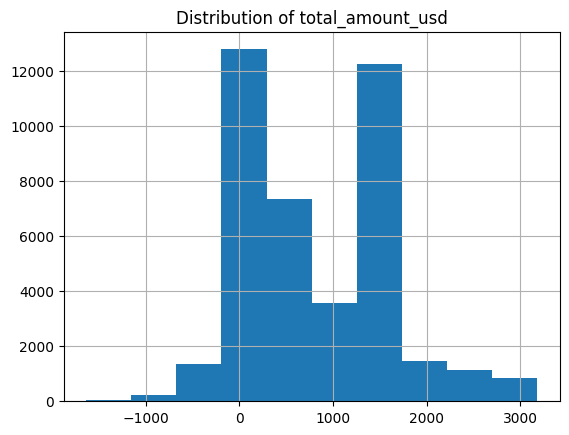

In [60]:
plt.title('Distribution of total_amount_usd')
users_data_wout_outliers.total_amount_usd.hist();

In [61]:
#Split the data into target and features
target_data = users_data_wout_outliers.total_amount_usd 
features = users_data_wout_outliers.drop(['user_id', 'total_amount_usd'],
                                         axis = 1)

In [62]:
target_data.info()

<class 'pandas.core.series.Series'>
Index: 41043 entries, 0 to 45215
Series name: total_amount_usd
Non-Null Count  Dtype  
--------------  -----  
41043 non-null  float64
dtypes: float64(1)
memory usage: 641.3 KB


In [63]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41043 entries, 0 to 45215
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   number_transactions  41043 non-null  float64
 1   job_management       41043 non-null  int64  
 2   job_technician       41043 non-null  int64  
 3   job_entrepreneur     41043 non-null  int64  
 4   job_blue-collar      41043 non-null  int64  
 5   job_retired          41043 non-null  int64  
 6   job_admin.           41043 non-null  int64  
 7   job_services         41043 non-null  int64  
 8   job_self-employed    41043 non-null  int64  
 9   job_unemployed       41043 non-null  int64  
 10  job_housemaid        41043 non-null  int64  
 11  job_student          41043 non-null  int64  
 12  education_tertiary   41043 non-null  int64  
 13  education_secondary  41043 non-null  int64  
 14  education_Unknown    41043 non-null  int64  
 15  education_primary    41043 non-null  int6

In [64]:
#Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target_data,
                                                    test_size = 0.3)

In [65]:
print('Training-data features: ', X_train.shape)
print('Training-data target:   ', y_train.shape)

Training-data features:  (28730, 31)
Training-data target:    (28730,)


In [66]:
#Check the distribution of the test data
print('Test-data features: ', X_test.shape)
print('Test-data target:   ', y_test.shape)

Test-data features:  (12313, 31)
Test-data target:    (12313,)


In [67]:
y_test.describe()

count    12313.000000
mean       794.124498
std        765.840040
min      -1629.000000
25%        121.000000
50%        655.000000
75%       1369.420000
max       3181.000000
Name: total_amount_usd, dtype: float64

In [68]:
#Train a linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [69]:
#Make predictions using the linear regression model
linreg_y_pred = linreg.predict(X_test) 

In [70]:
results = pd.concat([y_test.iloc[:5], X_test.iloc[:5]], axis = 1)
results.insert(1, 'total_pred', linreg_y_pred[:5].round(2))
results

,total_amount_usd,total_pred,number_transactions,job_management,job_technician,job_entrepreneur,job_blue-collar,job_retired,job_admin.,job_services,...,duration,campaign,pdays,previous,term_deposit,device_desktop,device_tablet,single,age_group_encoded,month_joined
33025,104.00,856.80,3.0,0,0,0,1,0,0,0,...,317,3,324,2,False,0,0,0,3,9
1893,1369.42,1129.94,0.0,0,1,0,0,0,0,0,...,551,2,-1,0,False,0,0,0,4,9
26956,219.00,994.59,2.0,0,0,0,1,0,0,0,...,729,1,-1,0,True,1,0,0,3,9
38050,170.00,829.65,2.0,0,0,0,1,0,0,0,...,113,3,367,4,False,0,0,0,1,3
19663,53.00,816.78,3.0,1,0,0,0,0,0,0,...,165,3,-1,0,False,0,0,1,1,10


In [71]:
#Obtain the linear regression model's score
r2_score(y_test, linreg_y_pred)

0.23321527124088082

In [72]:
#Train a decision-tree model

reg_tree = DecisionTreeRegressor()
reg_tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [73]:
#Make predictions using the decision-tree model
reg_tree_y_pred = reg_tree.predict(X_test)

In [74]:
results['total_pred'] = reg_tree_y_pred[:5]
results

,total_amount_usd,total_pred,number_transactions,job_management,job_technician,job_entrepreneur,job_blue-collar,job_retired,job_admin.,job_services,...,duration,campaign,pdays,previous,term_deposit,device_desktop,device_tablet,single,age_group_encoded,month_joined
33025,104.00,2958.00,3.0,0,0,0,1,0,0,0,...,317,3,324,2,False,0,0,0,3,9
1893,1369.42,1369.42,0.0,0,1,0,0,0,0,0,...,551,2,-1,0,False,0,0,0,4,9
26956,219.00,2787.00,2.0,0,0,0,1,0,0,0,...,729,1,-1,0,True,1,0,0,3,9
38050,170.00,59.00,2.0,0,0,0,1,0,0,0,...,113,3,367,4,False,0,0,0,1,3
19663,53.00,862.00,3.0,1,0,0,0,0,0,0,...,165,3,-1,0,False,0,0,1,1,10


In [75]:
#Obtain the decision-tree model's score
r2_score(y_test, reg_tree_y_pred)

-0.40313871451252936

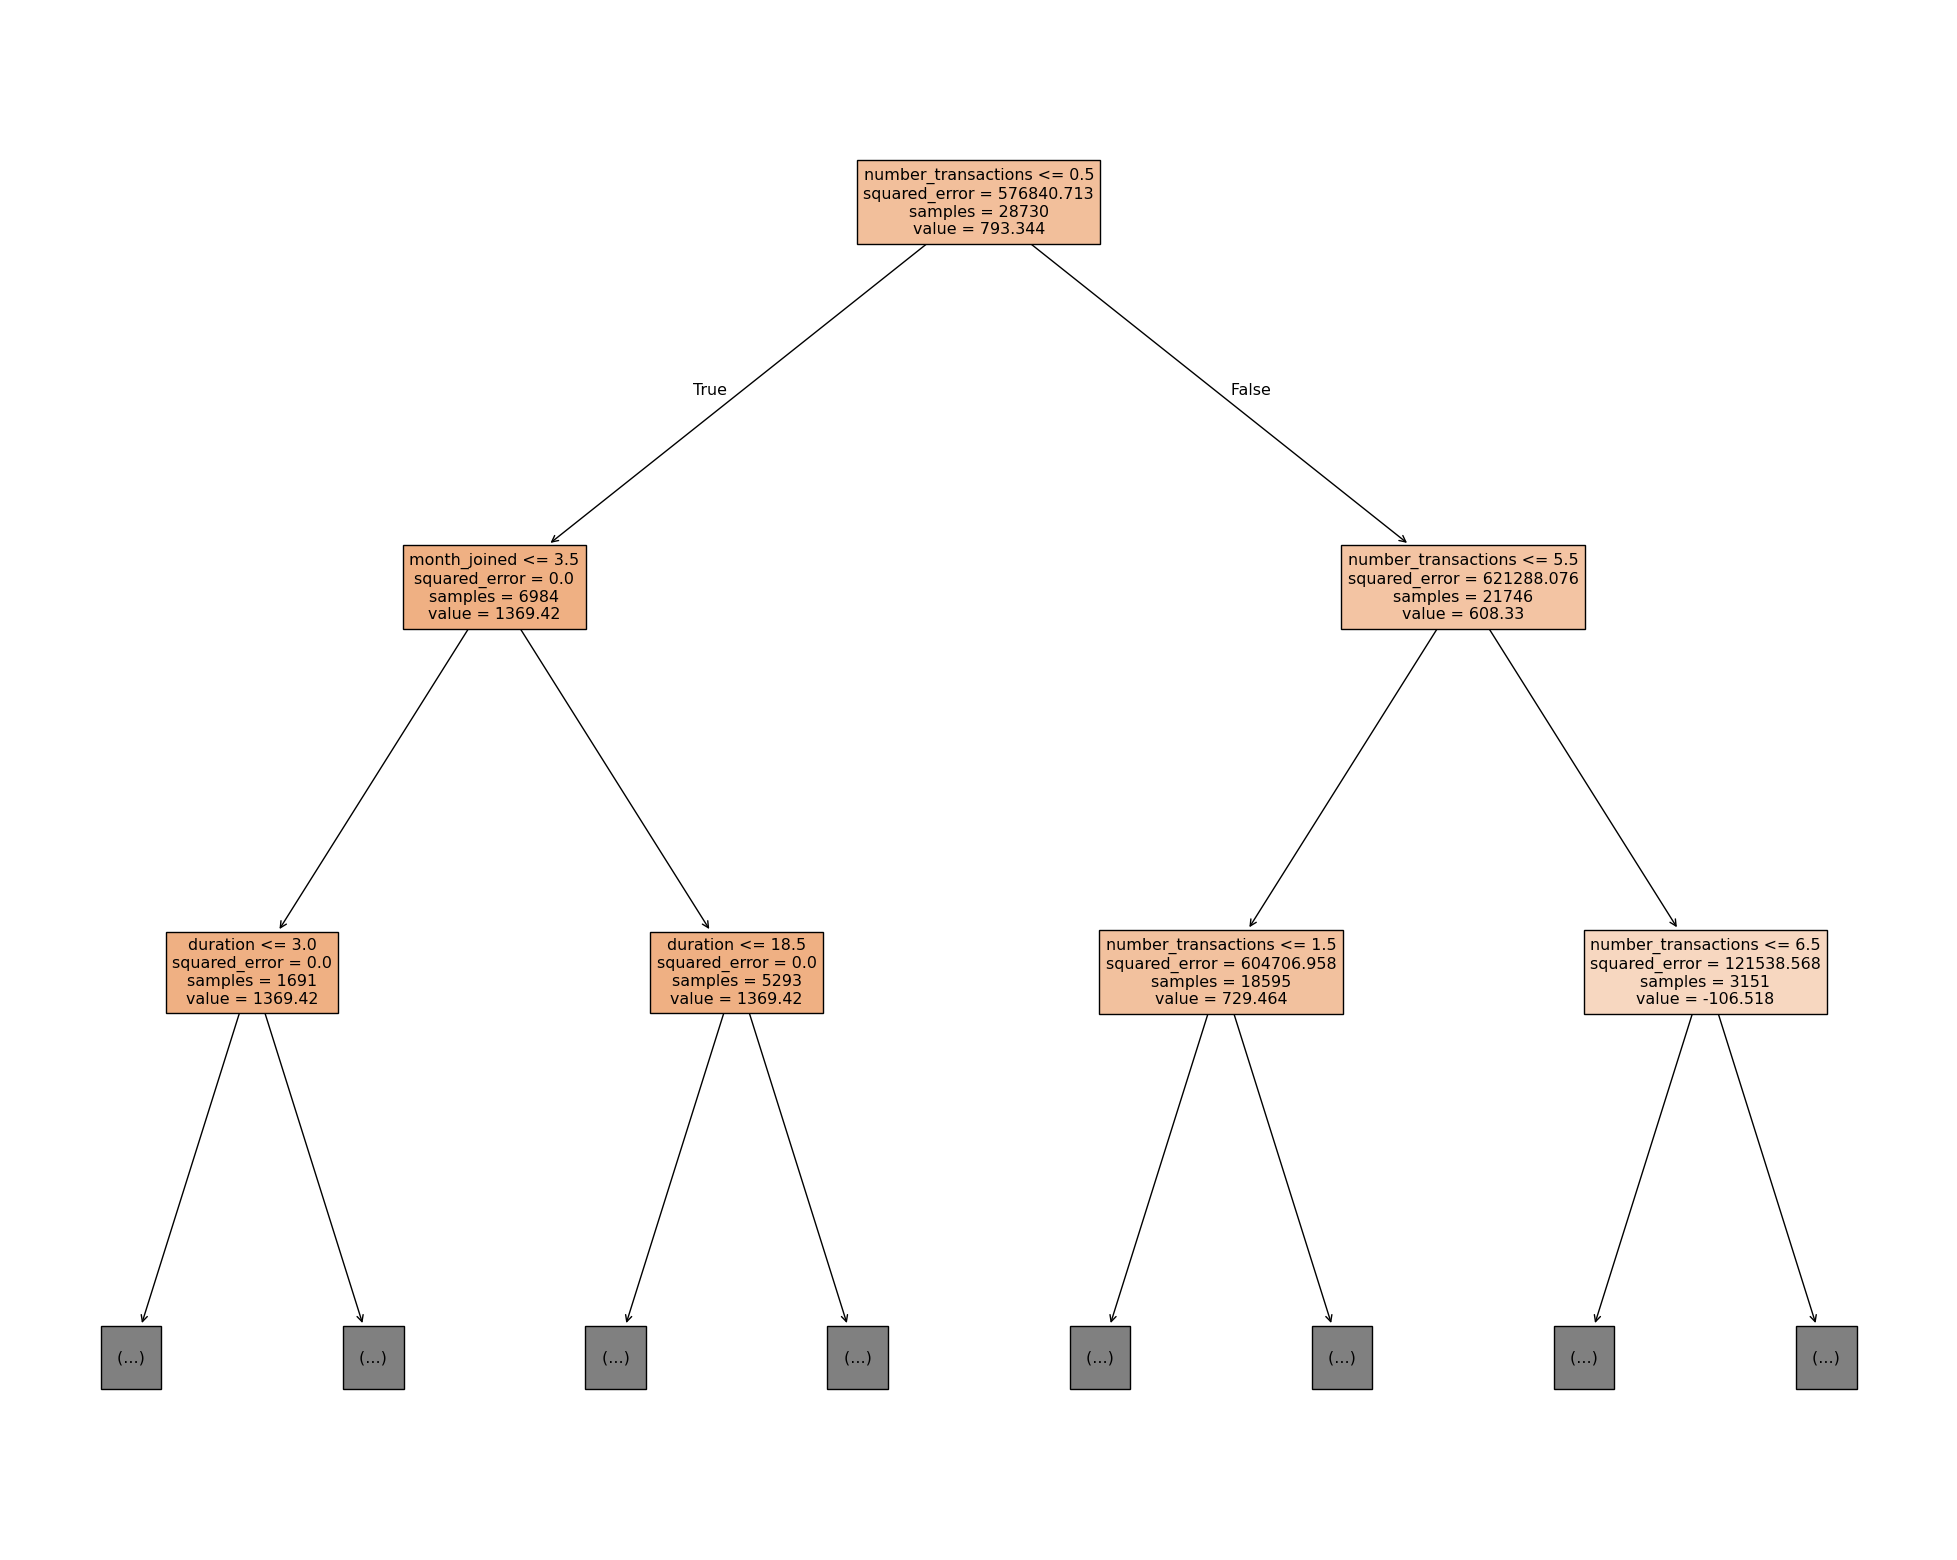

In [101]:
#Visualize the decision tree
fig = plt.figure(figsize = (25, 20))
_ = tree.plot_tree(reg_tree, 
                   feature_names = list(X_train.columns),
                   max_depth = 2,
                   filled = True)

In [77]:
#Train a random-forest model
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [78]:
#Make predictions using the random-forest model
rf_y_pred = rf.predict(X_test)

In [79]:
results['total_pred'] = rf_y_pred[:5]
results

,total_amount_usd,total_pred,number_transactions,job_management,job_technician,job_entrepreneur,job_blue-collar,job_retired,job_admin.,job_services,...,duration,campaign,pdays,previous,term_deposit,device_desktop,device_tablet,single,age_group_encoded,month_joined
33025,104.00,1187.61,3.0,0,0,0,1,0,0,0,...,317,3,324,2,False,0,0,0,3,9
1893,1369.42,1369.42,0.0,0,1,0,0,0,0,0,...,551,2,-1,0,False,0,0,0,4,9
26956,219.00,1134.88,2.0,0,0,0,1,0,0,0,...,729,1,-1,0,True,1,0,0,3,9
38050,170.00,514.93,2.0,0,0,0,1,0,0,0,...,113,3,367,4,False,0,0,0,1,3
19663,53.00,969.48,3.0,1,0,0,0,0,0,0,...,165,3,-1,0,False,0,0,1,1,10


In [80]:
#Obtain the random-forest model's score
r2_score(y_test, rf_y_pred)

0.29556907062128646

In [81]:
#Train a gradient-boosting model
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [82]:
#Make predictions using the gradient-boosting model
xgb_y_pred = xgb.predict(X_test)

In [83]:
results['total_pred'] = xgb_y_pred[:5]
results


,total_amount_usd,total_pred,number_transactions,job_management,job_technician,job_entrepreneur,job_blue-collar,job_retired,job_admin.,job_services,...,duration,campaign,pdays,previous,term_deposit,device_desktop,device_tablet,single,age_group_encoded,month_joined
33025,104.00,770.807617,3.0,0,0,0,1,0,0,0,...,317,3,324,2,False,0,0,0,3,9
1893,1369.42,1427.224365,0.0,0,1,0,0,0,0,0,...,551,2,-1,0,False,0,0,0,4,9
26956,219.00,923.411438,2.0,0,0,0,1,0,0,0,...,729,1,-1,0,True,1,0,0,3,9
38050,170.00,461.289276,2.0,0,0,0,1,0,0,0,...,113,3,367,4,False,0,0,0,1,3
19663,53.00,754.215393,3.0,1,0,0,0,0,0,0,...,165,3,-1,0,False,0,0,1,1,10


In [84]:
#Obtain the gradient-boosting model's score
r2_score(y_test, xgb_y_pred)

0.3066909539555063

In [85]:
#Define the parameter grid used to tune the linear regression model

param_grid = {'l1_ratio': [0.1, 0.5, 0.9],
              'alpha': [0.0001, 0.01, 0.1],
              'max_iter': [100, 1000, 10000]}

print(param_grid)


{'l1_ratio': [0.1, 0.5, 0.9], 'alpha': [0.0001, 0.01, 0.1], 'max_iter': [100, 1000, 10000]}


In [86]:
#Perform a grid search for optimal elastic net hyperparameters

model = ElasticNet()
gs = GridSearchCV(estimator = model,
                  param_grid = param_grid,
                  n_jobs = -1,
                  verbose = 2)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.01, 0.1],
                         'l1_ratio': [0.1, 0.5, 0.9],
                         'max_iter': [100, 1000, 10000]},
             verbose=2)

In [87]:
print('Best R2 score:   ', round(gs.best_score_, 4))
print('Best parameters: ', gs.best_params_)

Best R2 score:    0.2343
Best parameters:  {'alpha': 0.01, 'l1_ratio': 0.9, 'max_iter': 100}


In [88]:
#Define the parameter grid used to tune the decision-tree model
param_grid = {'max_depth': [5, 10, 20],
              'min_samples_split': [10, 100, 1000],
              'min_samples_leaf': [10, 100, 1000]}

print(param_grid)

{'max_depth': [5, 10, 20], 'min_samples_split': [10, 100, 1000], 'min_samples_leaf': [10, 100, 1000]}


In [89]:
#Perform a grid search for optimal decision-tree hyperparameters
model = DecisionTreeRegressor()
gs = GridSearchCV(estimator = model,
                  param_grid = param_grid,
                  n_jobs = -1,
                  verbose = 2)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20],
                         'min_samples_leaf': [10, 100, 1000],
                         'min_samples_split': [10, 100, 1000]},
             verbose=2)

In [90]:
print('Best R2 score:   ', round(gs.best_score_, 4))
print('Best parameters: ', gs.best_params_)

Best R2 score:    0.3357
Best parameters:  {'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 1000}


In [91]:
#Compare evaluation metrics for each model

models = ['Linear Regression', 'Decision Tree',
          'Random Forest', 'XGBoost', 'Dummy Regressor']

metrics = ['R2', 'MAE', 'MSE']

pred_list = ['linreg_y_pred', 'reg_tree_y_pred',
             'rf_y_pred', 'xgb_y_pred', 'dummy_y_pred']

# Baseline algorithm.
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy_y_pred = dummy.predict(X_test)

scores = np.empty((0, 3))

for i in pred_list:
    scores = np.append(scores,
                       np.array([[r2_score(y_test, globals()[i]),
                                  mean_absolute_error(y_test, globals()[i]),
                                  mean_squared_error(y_test, globals()[i])]]),
                       axis = 0)

scores = np.around(scores, 4)

scoring_df = pd.DataFrame(scores, index = models, columns = metrics)
scoring_df.sort_values(by = 'MSE', ascending = True)

,R2,MAE,MSE
XGBoost,0.3067,433.0251,406600.3341
Random Forest,0.2956,424.5515,413122.9109
Linear Regression,0.2332,531.7977,449691.1279
Dummy Regressor,-0.0000,656.6227,586463.9422
Decision Tree,-0.4031,561.2292,822889.4076


In [92]:
#Plot the residuals

# Set up data frame for plotting.

resid_df = pd.DataFrame()
resid_df['total_amount_usd'] = y_test
resid_df['total_pred'] = xgb_y_pred
resid_df['residuals'] = resid_df['total_amount_usd'] - resid_df['total_pred']
resid_df = resid_df.sort_values('total_amount_usd')[::20]
resid_df['record_num'] = np.arange(len(resid_df))

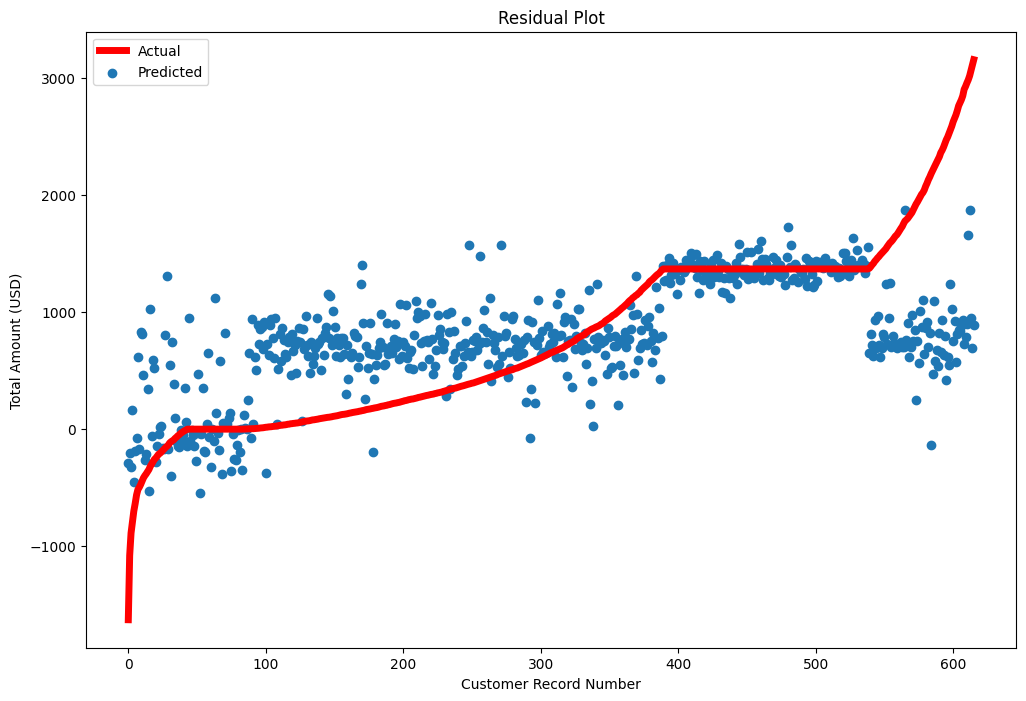

In [93]:
plt.figure(figsize = (12, 8))

plt.plot(resid_df['record_num'], resid_df['total_amount_usd'],
         color = 'red', linewidth = 5)
plt.scatter(resid_df['record_num'], resid_df['total_pred'])

plt.legend(['Actual', 'Predicted'])
plt.title('Residual Plot')
plt.ylabel('Total Amount (USD)')
plt.xlabel('Customer Record Number')
plt.show();

In [94]:
#Generate a feature-importance plot

def feature_importance_plot(model, X_train, n):
    """Plots feature importance. Only works for ensemble learning."""
    plt.figure(figsize = (8, 5))
    feat_importances = pd.Series(model.feature_importances_,
                                 index = X_train.columns)
    feat_importances.nlargest(n).plot(kind = 'barh')
    plt.title(f'Top {n} Features')
    plt.show()

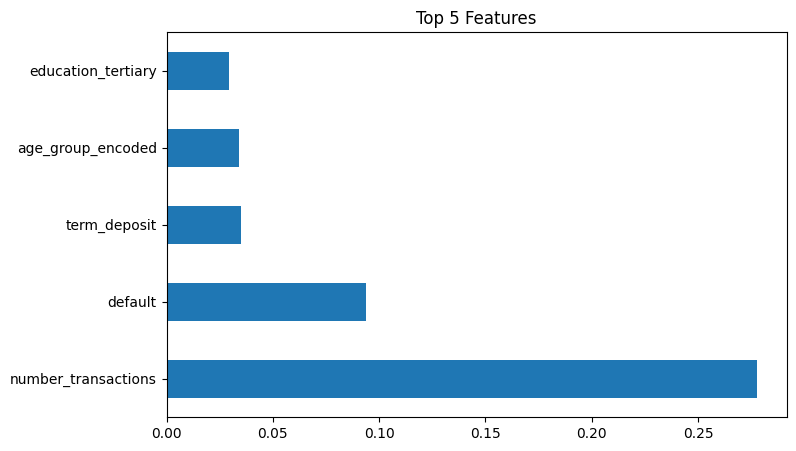

In [95]:
feature_importance_plot(xgb, X_train, 5)

In [96]:
#Plot learning curves

def plot_learning_curves(model, X_train, y_train):
    """Plots learning curves for model validation."""
    plt.figure(figsize = (5, 5))
    train_sizes, train_scores, test_scores = \
    learning_curve(model, X_train, y_train, cv = 5,
                   scoring = 'neg_mean_squared_error',
                   n_jobs = -1,
                   shuffle = True,
                   train_sizes = np.linspace(0.01, 1.0, 5))
        
    # Means of training and test set scores.
    train_mean = np.mean(train_scores, axis = 1)
    test_mean = np.mean(test_scores, axis = 1)

    # Draw lines.
    plt.plot(train_sizes, train_mean, '--',
             color = '#111111', label = 'Training score')
    plt.plot(train_sizes, test_mean,
             color = '#111111', label = 'Cross-validation score')

    # Create plot.
    plt.title('Learning Curves')
    plt.xlabel('Training Set Size')
    plt.ylabel('Negative MSE')
    plt.legend(loc = 'best')
    plt.tight_layout()

    plt.show()

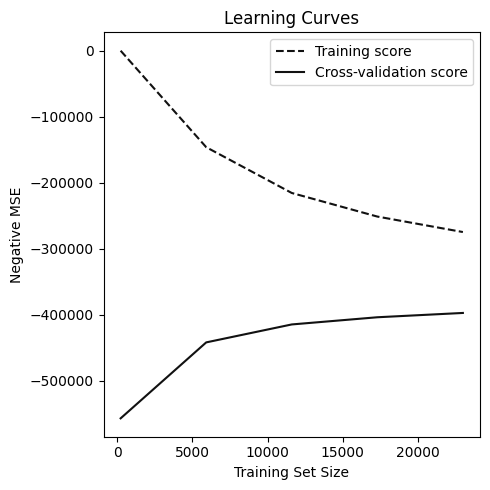

In [97]:
plot_learning_curves(xgb, X_train, y_train)

In [98]:
#Save the best model
pickle.dump(xgb, open('xgboost_regressor.pickle', 'wb'))